# Evaluating basis functions of the Shim Loops

In [1]:
import argparse
import signal
import subprocess
import sys
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import time
from helpersFunctions import *
import ipywidgets as widgets
from IPython.display import display, clear_output

sys.path.append('..')

from shimTool.Tool import Tool, ShimMode
from shimTool.dicomUtils import *
from shimTool.shimCompute import *

In [17]:
# the goal is to take a bunch of fieldmap for every coil independently with a bunch of different currents...
# and then check to see if the fieldmap is linearly correlated with the current for every coil

def applyCurrentGetFieldmap(tool: Tool, loopIdx: int, current: float):
    tool.shimInstance.shimZero()
    tool.shimInstance.shimSetCurrentManual(loopIdx, current)
    tool.doFieldmapScan()
    return computeFieldmapFromLatestFieldmapScan(tool)

def applyGradientGetFieldmap(tool: Tool, gradient: list):
    tool.shimInstance.shimZero()
    tool.setLinGradients(gradient)
    tool.doFieldmapScan()
    return computeFieldmapFromLatestFieldmapScan(tool)

def plotDivAvgsOfReference(reference, referenceCurrent, fieldmaps, currents, loopIdx):
    """
    divide each fieldmap by the reference
    take the nanmean of each divided fieldmap
    plot the result of the nanmean vs the current
    ---
    reference: fieldmap at 1 amp
    referencecurrent: current of the reference map
    fieldmaps: array of fieldmaps at different currents
    currents: array of currents references by fieldmaps
    looplabel: label for the loop that is being analyzed
    """
    # remake the lists so that we don't modify the original
    fieldmaps = [fieldmap.copy() for fieldmap in fieldmaps]
    currents = currents.copy() 

    fieldmaps.append(reference)
    currents.append(referenceCurrent)
    # divide each fieldmap by the reference
    dividedfieldmaps = [np.divide(fieldmap,reference) for fieldmap in fieldmaps]
    # take the nanmean of each divided fieldmap
    nanmeandividedfieldmaps = [np.nanmean(div) for div in dividedfieldmaps]
    nanstddividedfieldmaps = [np.nanstd(div) for div in dividedfieldmaps]

    print(f"nanstds of the divided fieldmaps: {nanstddividedfieldmaps} for currents: {currents}")
    # plot the result of the nanmean vs the current
    plt.plot(currents, nanmeandividedfieldmaps, 'o')
    plt.xlabel('current (a)')
    plt.ylabel('avg offresonance multiple from reference')
    plt.title(f'fieldmap multiple vs current for loop {loopIdx} at {referenceCurrent}A')
    plt.grid()
    plt.show()

def acquireCoil(tool: Tool, loopIdx: int, referenceCurrent: float, currents:list[float], background:np.ndarray):
    def printAnnounce(msg):
        print("----------------------------------------")
        print(f"|{msg}|")
        print("----------------------------------------")
    printAnnounce(f"Acquiring reference fieldmap for Loop {loopIdx} with ref current {referenceCurrent}")
    reference = applyCurrentGetFieldmap(tool, loopIdx, referenceCurrent)
    reference = reference - background
    fieldmaps = []
    for current in currents:
        printAnnounce(f" * Acquiring fieldmap for Loop {loopIdx} with current {current}")
        fieldmap = applyCurrentGetFieldmap(tool, loopIdx, current)
        fieldmaps.append(fieldmap - background)
    return reference, fieldmaps

def acquireGradient(tool:Tool, refGradient, ticks, background: np.ndarray):
    print(f"Acquiring fieldmap for gradient {refGradient}")
    fieldmap = applyGradientGetFieldmap(tool, refGradient)
    reference = fieldmap - background
    fieldmaps = []
    for tick in ticks:
        print(f"Acquiring fieldmap for gradient {tick}")
        fieldmap = applyGradientGetFieldmap(tool, tick)
        fieldmaps.append(fieldmap - background)
    return reference, fieldmaps

In [3]:
# create a new shim tool object
tool = load_tool()

/home/heartvista/Documents/robert/ge3t_shim_tool/logs/scannerLog.txt
/home/heartvista/Documents/robert/ge3t_shim_tool/logs/arduinoLog.txt
/home/heartvista/Documents/robert/ge3t_shim_tool/logs/guiLog.txt
INFO SHIM CLIENT: Serial port opened successfully
INFO EXSI CLIENT: Socket connected
08:25:28 SHIM TOOL: waiting for connection
EXSI CLIENT DEBUG: Processing command:  ConnectToScanner product=newHV passwd=rTpAtD
EXSI CLIENT DEBUG: Processing command:  NotifyEvent all=on
Debug SHIM CLIENT: recieved msg: Ccalibrating a channel
Debug SHIM CLIENT: recieved msg: calibrated a channel
Debug SHIM CLIENT: recieved msg: calibrating a channel
EXSI CLIENT DEBUG: Processing command:  GetExamInfo
08:25:28 SHIM TOOL: done waiting for connection
08:25:28 SHIM TOOL: Shim Tool is ready to use.


Debug SHIM CLIENT: recieved msg: calibrated a channel
Debug SHIM CLIENT: recieved msg: calibrating a channel
Debug SHIM CLIENT: recieved msg: calibrated a channel
Debug SHIM CLIENT: recieved msg: calibrating a channel
Debug SHIM CLIENT: recieved msg: calibrated a channel
Debug SHIM CLIENT: recieved msg: calibrating a channel
Debug SHIM CLIENT: recieved msg: calibrated a channel
Debug SHIM CLIENT: recieved msg: calibrating a channel
Debug SHIM CLIENT: recieved msg: calibrated a channel
Debug SHIM CLIENT: recieved msg: calibrating a channel
Debug SHIM CLIENT: recieved msg: calibrated a channel
Debug SHIM CLIENT: recieved msg: calibrating a channel
Debug SHIM CLIENT: recieved msg: calibrated a channel
Debug SHIM CLIENT: recieved msg: Done Calibrating
INFO SHIM CLIENT: Connection Created successfully
EXSI CLIENT DEBUG: Processing command:  LoadProtocol site path="ConformalShimCalibration4"
EXSI CLIENT DEBUG: Task keys found in message:  [76]
EXSI CLIENT DEBUG: Processing command:  SelectTa

In [4]:
# want to get a background
tool.doCalibrationScan()
#tool.exsiInstance.bedPosition = 0
tool.doFieldmapScan()
background = computeFieldmapFromLatestFieldmapScan(tool)

08:26:09 SHIM TOOL: Initiating transfer using rsync.
08:26:09 SHIM TOOL: obtained exam data path: /export/home1/sdc_image_pool/images/p2/e2039
08:26:10 SHIM TOOL: resetting???
08:26:10 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
08:26:10 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
EXSI CLIENT DEBUG: found that the last bed position was -22 mm
08:26:54 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
08:26:54 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
08:27:19 SHIM TOOL: Done. 2 scans completed!
08:27:19 SHIM TOOL: Initiating transfer using rsync.
08:27:20 SHIM TOOL: Initiating transfer using rsync.
DEBUG: Extracted te1 1.104, name1 st
DEBUG: Extracted te2 4.604, name2 nd
08:27:21 SHIM TOOL: Computed Mask from background, basis and ROI.
08:27:21 SHIM TOOL: Masked obtained data and 'sent to GUI.'
08:27:21 SHIM TOOL: evaluating map 0
08:27:21 SHIM TOOL: finished setting the per slice stats for map 0
08:27:21 SHIM TOOL: fini

## trying it out with the gradients to see if this division method is viable to look into the loop performance

In [10]:
# sanity test with the gradients and that linearity...
refGradient = [10,0,0]
ticks = [[20,0,0], [30,0,0], [40,0,0], [50,0,0]]


In [8]:
reference, fieldmaps = acquireGradient(tool, refGradient, ticks, background)
# b0maps = compute_b0maps(5, tool.localExamRootDir)
# reference = b0maps[0]
# fieldmaps = b0maps[1:]

DEBUG: Extracted te1 1.104, name1 st
DEBUG: Extracted te2 4.604, name2 nd
DEBUG: Extracted te1 1.104, name1 st
DEBUG: Extracted te2 4.604, name2 nd
DEBUG: Extracted te1 1.104, name1 st
DEBUG: Extracted te2 4.604, name2 nd
DEBUG: Extracted te1 1.104, name1 st
DEBUG: Extracted te2 4.604, name2 nd
DEBUG: Extracted te1 1.104, name1 st
DEBUG: Extracted te2 4.604, name2 nd


nanstds of the divided fieldmaps: [131.20856076039797, 102.4884042010527, 66.3030279784834, 30.079513101430322, 0.0] for currents: [20, 30, 40, 50, 10]


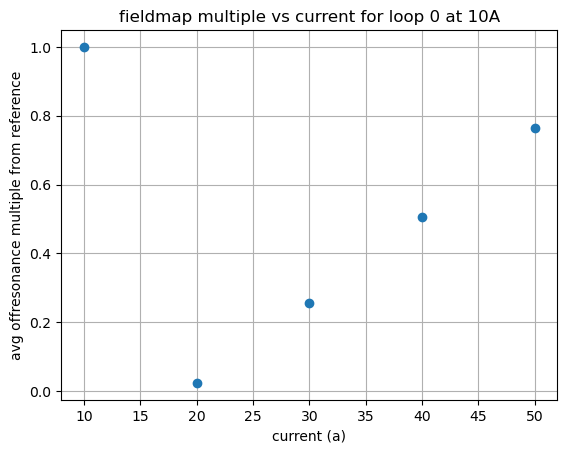

In [18]:
plotDivAvgsOfReference(reference, 10, fieldmaps, [20,30,40,50], 0)

### it seems to work exactly as it should... on average.

## Try to get similar results on a single coil

In [11]:
loopIdx = 2
referenceCurrent = 1.0
currents = [0.2,.4,0.6,0.8]

In [12]:
reference, fieldmaps = acquireCoil(tool, loopIdx, referenceCurrent, currents, background)

----------------------------------------
|Acquiring reference fieldmap for Loop 2 with ref current 1.0|
----------------------------------------
08:42:31 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
08:42:31 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
08:42:56 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
08:42:56 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
08:43:21 SHIM TOOL: Done. 2 scans completed!
08:43:21 SHIM TOOL: Initiating transfer using rsync.
08:43:22 SHIM TOOL: Initiating transfer using rsync.
08:43:22 SHIM TOOL: evaluating map 0
08:43:22 SHIM TOOL: finished setting the per slice stats for map 0
08:43:22 SHIM TOOL: finished setting the volume stats for map 0
08:43:22 SHIM TOOL: evaluating map 1
08:43:22 SHIM TOOL: evaluating map 2
DEBUG: Extracted te1 1.104, name1 st
DEBUG: Extracted te2 4.604, name2 nd
----------------------------------------
| * Acquiring fieldmap for Loop 2 with current 0.2|
-------------

nanstds of the divided fieldmaps: [131.20856076039797, 102.4884042010527, 66.3030279784834, 30.079513101430322, 0.0] for currents: [0.2, 0.4, 0.6, 0.8, 1.0]


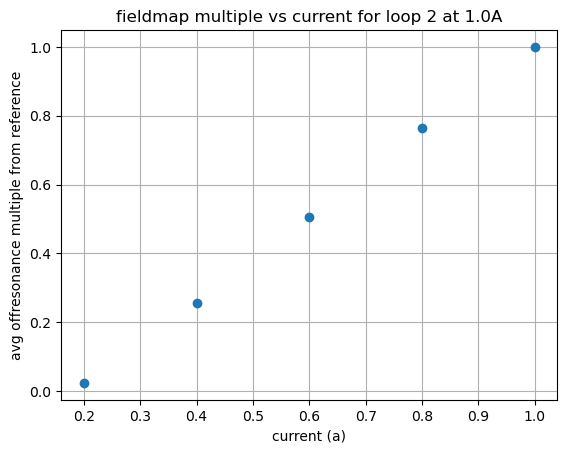

In [19]:
plotDivAvgsOfReference(reference, referenceCurrent, fieldmaps, currents, loopIdx)

## do the above procedure for all of the coils!

----------------------------------------
|Acquiring reference fieldmap for Loop 0 with ref current 1.0|
----------------------------------------
08:52:55 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
08:52:55 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
08:53:20 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
08:53:20 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
08:53:45 SHIM TOOL: Done. 2 scans completed!
08:53:45 SHIM TOOL: Initiating transfer using rsync.
08:53:45 SHIM TOOL: Initiating transfer using rsync.
08:53:46 SHIM TOOL: evaluating map 0
08:53:46 SHIM TOOL: finished setting the per slice stats for map 0
08:53:46 SHIM TOOL: finished setting the volume stats for map 0
08:53:46 SHIM TOOL: evaluating map 1
08:53:46 SHIM TOOL: evaluating map 2
DEBUG: Extracted te1 1.104, name1 st
DEBUG: Extracted te2 4.604, name2 nd
----------------------------------------
| * Acquiring fieldmap for Loop 0 with current -1.5|
------------

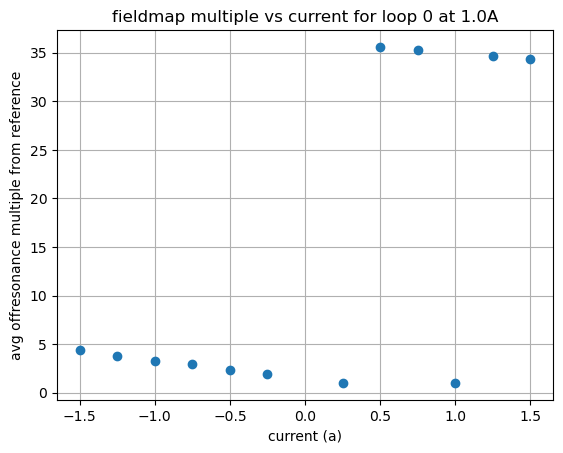

----------------------------------------
|Acquiring reference fieldmap for Loop 1 with ref current 1.0|
----------------------------------------
09:03:22 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
09:03:22 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
09:03:48 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
09:03:48 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
09:04:12 SHIM TOOL: Done. 2 scans completed!
09:04:12 SHIM TOOL: Initiating transfer using rsync.
09:04:13 SHIM TOOL: Initiating transfer using rsync.
09:04:14 SHIM TOOL: evaluating map 0
09:04:14 SHIM TOOL: finished setting the per slice stats for map 0
09:04:14 SHIM TOOL: finished setting the volume stats for map 0
09:04:14 SHIM TOOL: evaluating map 1
09:04:14 SHIM TOOL: evaluating map 2
DEBUG: Extracted te1 1.104, name1 st
DEBUG: Extracted te2 4.604, name2 nd
----------------------------------------
| * Acquiring fieldmap for Loop 1 with current -1.5|
------------

KeyboardInterrupt: 

In [20]:
referenceCurrent = 1.0
currents = [-1.5,-1.25,-1,-0.75,-0.5,-0.25,0.25,0.5,0.75,1.25,1.5]
references = []
fieldmapss = []
for loopIdx in range(8):
    reference, fieldmaps = acquireCoil(tool, loopIdx, referenceCurrent, currents, background)
    references.append(reference)
    fieldmapss.append(fieldmaps)
    plotDivAvgsOfReference(reference, referenceCurrent, fieldmaps, currents, loopIdx)